# Autonomous driving using DQN  baseline methods *(endurot env)

In [1]:
# import the libraries used                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
import gym
%matplotlib inline
from Agent import agent

In [2]:
# Load the environement. Here you need to adjust the filename.
env = gym.make('Enduro-v0')
env.reset()
action_size=9

print("action space",env.action_space)
print("observation space",env.observation_space)
# 0 = straight
# 1 = left
# 2 = right


action space Discrete(9)
observation space Box(210, 160, 3)


In [3]:
def post_poc(screen):
    screen = np.asarray(screen[66:150,68:152])
    for i in range(len(screen)):
        for j in range(len(screen[0])):
            screen[i,j,0] = 0.2989 * screen[i,j,0] + 0.5870 * screen[i,j,1] + 0.1140 * screen[i,j,2]
    screen=screen[:,:,0].reshape(1,84,84)
 

    return screen

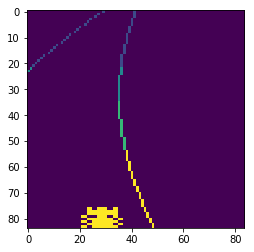

In [4]:
for i_episode in range(1):
    current_screen = post_poc(env.reset()) 
    last_screen = current_screen 
    for t in range(38):
        env.render()
        action =7# env.action_space.sample()
        #print("action:",info)
        current_screen, reward, done, info = env.step(action)
        current_screen=post_poc(current_screen)
        next_state=current_screen
        last_screen=current_screen     
        plt.imshow(next_state[0])
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

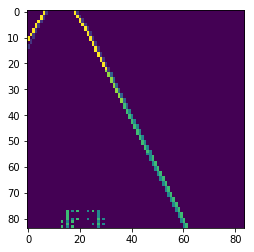

In [5]:
for i_episode in range(1):
    current_screen = post_poc(env.reset()) 
    last_screen = current_screen 
    for t in range(11):
        env.render()
        action =7#env.action_space.sample()
        #print("action:",info)
        current_screen, reward, done, info = env.step(action)
        current_screen=post_poc(current_screen)
        next_state=last_screen-current_screen
        last_screen=current_screen     
        plt.imshow(next_state[0])
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

In [6]:

#    0 - walk forward
#    1 - walk backward
#    2 - turn left
#    3 - turn right 

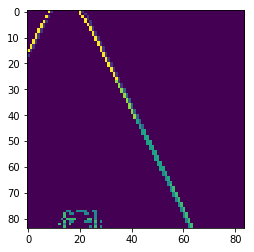

In [7]:
for i_episode in range(10):
    current_screen = post_poc(env.reset()) 
    last_screen = current_screen 
    for t in range(10):
        env.render()
        action =env.action_space.sample()
        #print("action:",info)
        current_screen, reward, done, info = env.step(action)
        current_screen=post_poc(current_screen)
        next_state=last_screen-current_screen
        last_screen=current_screen     
        plt.imshow(next_state[0])
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

In [8]:
def Test(env,agent,file_name,max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    agent.qnetwork_local.load_state_dict(torch.load(file_name))
 
    scores = []                        # list containing scores from each episode
    score = 0

    env_info = env.reset()
    score = 0
    t=0
    for i_episode in range(2):
        screen_3 = post_poc(env.reset()) 
        screen_2 = screen_3
        screen_1 = screen_3
        screen_0 = screen_3
        state=np.array(screen_0,screen_1)
        for t in range(max_t):
            env.render()
            action = agent.act(state)
            #print("action:",info)
            screen_0, reward, done, info = env.step(action)
            screen_0=post_poc(screen_0)
            next_state=np.array(screen_0,screen_1)
            state=next_state
            # roll over the state to next time step
            score += reward      # update the score
            scores.append(score)              # save most recent score
            if done or t>= max_t:
                break
        print("Average reward par step:",score/t)
    return scores

In [ ]:
def plot_data(x,y,xlabel='Episode #',ylabel='Score',title="Results"):
  # plot the scores
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(x, y)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(title, fontsize=16, fontweight='bold')
  plt.show()

## Training

In [ ]:
state_size=(55,100)
state_size=(84,84)

def train(env,agent,dqn,file_save='checkpoint.pth',n_episodes=10000, max_t=100000, eps_start=1.0, eps_end=0.1,eps_decay=0.95):
  
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
 
    scores = []                        # list containing scores from each episode
    scores_mean=[]                     # list containing the mean score at each step
    scores_std=[]                      # list containing standart deviation at each step
    scores_window = deque(maxlen=100)  # last 100 scores

    eps = eps_start 
    i_step=0# initialize epsilon
    for i_episode in range(1, n_episodes+1):
        screen_0 = post_poc(env.reset())
        screen_1 = screen_0
        screen_2 = screen_0
        screen_3 = screen_0
        state=np.array([screen_0,screen_1,screen_2,screen_3]).reshape(1,4,state_size[0],state_size[1])
        
        score = 0
        eps=eps_start
        for t in range(1000000000000000):
            env.render()
            #plt.imshow(state[0])

           # if(i_step<10000):
           #     action = agent.act(state, 0.05)
           #     i_step +=1
           # else:
            action = agent.act(state, eps)
            screen_0, reward, done, info = env.step(action)
            screen_0 = post_poc(screen_0)
            next_state = np.array([screen_0,screen_1,screen_2,screen_3]).reshape(1,4,state_size[0],state_size[1])

             # information about the environment
            #print("vector len",len(state[0][0]),len(state[0][0][0]),len(next_state[0][0]),len(next_state[0][0][0]))
            agent.step(state_size,state, action, reward, next_state, done,dqn)
            screen_3 = screen_2
            screen_2 = screen_1
            screen_1 = screen_0
          
            score += reward      # update the score
            state = next_state   # roll over the state to next time step
            if done:             # exit loop if episode finished
                break
 
        scores_window.append(score)                     # save most recent score
        scores.append(score)                            # save most recent score
        scores_mean.append(np.mean(scores_window))      # save most recent mean score last 100 scores
        scores_std.append(np.std(scores_window))        # save most recent standart deviation over last 100 scores        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon


        if i_episode % 1 == 0:
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode,score,reward,done))
             
        if i_episode % 50 == 0:         
           #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), file_save)

        #if np.mean(scores_window)>=13.0:
        #    #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,scores_window)))
        #    torch.save(agent.qnetwork_local.state_dict(), file_save)
        #    break

    return scores,scores_mean, scores_std

### DQN

In [ ]:
dqn_agent = agent(state_size, action_size,duel=False, fc1_units=64,fc2_units=64,seed=0)
dqn_scores,dqn_scores_mean, dqn_scores_std  = train(env,dqn_agent,dqn=True,file_save='dqn_checkpoint.pth')

QNetwork(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LN1): Linear(in_features=2592, out_features=256, bias=True)
  (LN2): Linear(in_features=256, out_features=9, bias=True)
)
Episode 1	Score: 0.00
Episode 2	Score: 0.00
Episode 3	Score: 0.00
Episode 4	Score: 0.00
Episode 5	Score: 0.00
Episode 6	Score: 0.00
Episode 7	Score: 0.00
Episode 8	Score: 0.00
Episode 9	Score: 0.00
Episode 10	Score: 0.00
Episode 11	Score: 0.00
Episode 12	Score: 0.00
Episode 13	Score: 0.00
Episode 14	Score: 0.00
Episode 15	Score: 0.00
Episode 16	Score: 0.00
Episode 17	Score: 0.00
Episode 18	Score: 0.00
Episode 19	Score: 0.00
Episode 20	Score: 0.00
Episode 21	Score: 0.00
Episode 22	Score: 0.00
Episode 23	Score: 0.00
Episode 24	Score: 0.00
Episode 25	Score: 0.00


Episode 329	Score: 0.00
Episode 330	Score: 0.00
Episode 331	Score: 0.00
Episode 332	Score: 0.00
Episode 333	Score: 0.00
Episode 334	Score: 0.00
Episode 335	Score: 0.00
Episode 336	Score: 0.00
Episode 337	Score: 0.00
Episode 338	Score: 0.00
Episode 339	Score: 0.00
Episode 340	Score: 0.00
Episode 341	Score: 0.00
Episode 342	Score: 0.00
Episode 343	Score: 0.00
Episode 344	Score: 0.00
Episode 345	Score: 0.00
Episode 346	Score: 0.00
Episode 347	Score: 0.00
Episode 348	Score: 0.00
Episode 349	Score: 0.00
Episode 350	Score: 0.00
Episode 351	Score: 0.00
Episode 352	Score: 0.00
Episode 353	Score: 0.00
Episode 354	Score: 0.00
Episode 355	Score: 0.00
Episode 356	Score: 0.00
Episode 357	Score: 0.00
Episode 358	Score: 0.00
Episode 359	Score: 0.00
Episode 360	Score: 0.00
Episode 361	Score: 0.00
Episode 362	Score: 0.00
Episode 363	Score: 0.00
Episode 364	Score: 0.00
Episode 365	Score: 0.00
Episode 366	Score: 0.00
Episode 367	Score: 0.00
Episode 368	Score: 0.00
Episode 369	Score: 0.00
Episode 370	Scor

In [ ]:
plot_data(np.arange(len(dqn_scores)),dqn_scores,xlabel='Episode #',ylabel='Score',title="DQN")
plot_data(np.arange(len(dqn_scores_mean)),dqn_scores_mean,xlabel='Episode #',ylabel='Score avg',title="DQN")

### DDQN

In [ ]:
ddqn_agent = agent(state_size, action_size, duel=False, fc1_units=64,fc2_units=64,seed=0)
ddqn_scores,ddqn_scores_mean, ddqn_scores_std = train(env,brain_name,ddqn_agent,dqn=False,file_save='ddqn_checkpoint.pth')

In [ ]:
plot_data(np.arange(len(ddqn_scores)),ddqn_scores,xlabel='Episode #',ylabel='Score',title="DDQN")
plot_data(np.arange(len(ddqn_scores_mean)),ddqn_scores_mean,xlabel='Episode #',ylabel='Score avg',title="DDQN")

### Duelling DQN

In [ ]:

duel_dqn_agent = agent(state_size, action_size,duel=True, fc1_units=64,fc2_units=64,seed=0)
duel_dqn_scores,duel_dqn_scores_mean,duel_dqn_scores_std = train(env,brain_name,duel_dqn_agent,dqn=True,file_save='duel_dqn_checkpoint.pth')

In [ ]:
plot_data(np.arange(len(duel_dqn_scores)),duel_dqn_scores,ylabel='Score',title="Duel DQN")
plot_data(np.arange(len(duel_dqn_scores_mean)),duel_dqn_scores_mean,ylabel='Score avg',title="Duel DQN")

### Duelling DDQN

In [ ]:
duel_ddqn_agent = agent(state_size, action_size, duel=True, fc1_units=64,fc2_units=64,seed=0)
duel_ddqn_scores,duel_ddqn_scores_mean,duel_ddqn_scores_std = train(env,brain_name,duel_ddqn_agent,dqn=False,file_save='duel_ddqn_checkpoint.pth')

In [ ]:
plot_data(np.arange(len(duel_ddqn_scores)),duel_ddqn_scores,ylabel='Score',title="Duel DDQN")
plot_data(np.arange(len(duel_ddqn_scores_mean)),duel_ddqn_scores_mean,ylabel='Score avg',title="Duel DDQN")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_scores_mean)), dqn_scores_mean, color="red", label="DQN")
plt.plot(np.arange(len(ddqn_scores_mean)), ddqn_scores_mean, color="green", label="DDQN")
plt.plot(np.arange(len(duel_dqn_scores_mean)),duel_dqn_scores_mean,'-.',color="orange",label="Duel_DQN")
plt.plot(np.arange(len(duel_ddqn_scores_mean)),duel_ddqn_scores_mean,'-.',color="blue",label="Duel_DDQN")
plt.legend(loc='lower right')
plt.title("Comparison", fontsize=16, fontweight='bold')
plt.show()

## Testing

In [ ]:
brain_name, brain, env_info, action_size, state_size = initialize_env(env,train_mode=False,brain_id=0)

In [ ]:
agent = agent(state_size, action_size,duel=False, fc1_units=64,fc2_units=64,seed=0)
file_name ='ddqn_checkpoint.pth'

In [ ]:
scores=Test(env,brain_name,agent,file_name ,max_t=1000)

In [ ]:
plot_data(np.arange(len(scores)),scores,xlabel='Step #',ylabel='DQN Score')


# Fin

In [ ]:
env.close()